# **2474. Customers With Strictly Increasing Purchases**

**Table: Orders**
``` sql
+--------------+------+
| Column Name  | Type |
+--------------+------+
| order_id     | int  |
| customer_id  | int  |
| order_date   | date |
| price        | int  |
+--------------+------+
```
order_id is the column with unique values for this table.

Each row contains the id of an order, the id of customer that ordered it, the date of the order, and its price.
 

Write a solution to report the IDs of the customers with the total purchases strictly increasing yearly.

The total purchases of a customer in one year is the sum of the prices of their orders in that year. If for some year the customer did not make any order, we consider the total purchases 0.

The first year to consider for each customer is the year of their first order.

The last year to consider for each customer is the year of their last order.

Return the result table in any order.

The result format is in the following example.

 

**Example 1:**

**Input:** 
**Orders table:**
``` sql
+----------+-------------+------------+-------+
| order_id | customer_id | order_date | price |
+----------+-------------+------------+-------+
| 1        | 1           | 2019-07-01 | 1100  |
| 2        | 1           | 2019-11-01 | 1200  |
| 3        | 1           | 2020-05-26 | 3000  |
| 4        | 1           | 2021-08-31 | 3100  |
| 5        | 1           | 2022-12-07 | 4700  |
| 6        | 2           | 2015-01-01 | 700   |
| 7        | 2           | 2017-11-07 | 1000  |
| 8        | 3           | 2017-01-01 | 900   |
| 9        | 3           | 2018-11-07 | 900   |
+----------+-------------+------------+-------+
```
**Output:**
``` sql 
+-------------+
| customer_id |
+-------------+
| 1           |
+-------------+
```
**Explanation:** 

**Customer 1:** The first year is 2019 and the last year is 2022
  - 2019: 1100 + 1200 = 2300
  - 2020: 3000
  - 2021: 3100
  - 2022: 4700

We can see that the total purchases are strictly increasing yearly, so we include customer 1 in the answer.

**Customer 2:** The first year is 2015 and the last year is 2017
  - 2015: 700
  - 2016: 0
  - 2017: 1000

We do not include customer 2 in the answer because the total purchases are not strictly increasing. Note that customer 2 did not make any purchases in 2016.

**Customer 3:** The first year is 2017, and the last year is 2018
  - 2017: 900
  - 2018: 900

We do not include customer 3 in the answer because the total purchases are not strictly increasing.

**Solution-1:**

``` sql
WITH RECURSIVE cte1 AS (
    SELECT customer_id, 
           MIN(YEAR(order_date)) AS min_year, 
           MAX(YEAR(order_date)) AS max_year
    FROM orders
    GROUP BY customer_id
),
cte2 AS (
    -- Anchor member: Start with the minimum year
    SELECT customer_id, min_year
    FROM cte1
    UNION ALL
    -- Recursive member: Increment the year until it reaches the max year
    SELECT cte2.customer_id, cte2.min_year + 1
    FROM cte2
    JOIN cte1 ON cte2.customer_id = cte1.customer_id
    WHERE cte2.min_year < cte1.max_year
)
,cte3 as(
SELECT cte2.customer_id, cte2.min_year as year, 
coalesce(sum(price),0) as total_price
FROM cte2
LEFT JOIN orders
ON cte2.customer_id = orders.customer_id and cte2.min_year = year(order_date)
group by customer_id, year)

,cte4 as (
select customer_id,
case when total_price < lead(coalesce(total_price,0),1) over(partition by customer_id order by year)
then 1 else 0 end as cnt
from cte3)

select customer_id from cte4
group by customer_id
having (count(customer_id)-1) =  sum(cnt)
ORDER BY customer_id;



**Solution-2:**
``` sql
-- purchase of each customer by year
with yearly as
(select customer_id, year(order_date) year, sum(price) price
from orders
group by year(order_date),customer_id)
-- "left" join each year with its +1 year, and has strictly bigger purchase on +1 year.
select y1.customer_id
from yearly y1
left join yearly y2 
on y1.customer_id=y2.customer_id and y1.year+1=y2.year and y1.price<y2.price
group by y1.customer_id
having count(*)-count(y2.customer_id)=1

**Solution-3:**
``` sql
with cte as (
    select customer_id, year(order_date) year,
    lag(year(order_date)) over (partition by customer_id order by year(order_date)) last_year,
    rank() over (partition by customer_id order by year(order_date)) rnky,
    rank() over (partition by customer_id order by sum(price)) rnkp
    from Orders
    group by 1, 2
)
select distinct customer_id
from cte
where customer_id not in (
    select customer_id from cte 
    where last_year is not null and ((year-last_year)!=1 or rnky!=rnkp))

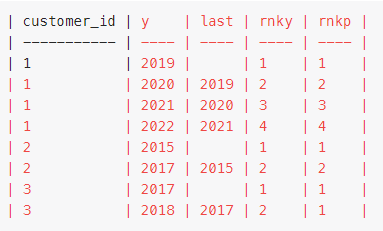

**Solution-4:**

``` sql
WITH RANKED AS (
    SELECT customer_id,
            order_year,
            RANK() OVER(PARTITION BY customer_id ORDER BY order_year) as r1,
            RANK() OVER(PARTITION BY customer_id ORDER BY total) as r2
    FROM (
        SELECT customer_id, YEAR(order_date) AS order_year, SUM(price) AS total
        FROM Orders
        GROUP BY customer_id, YEAR(order_date)
    ) g
)

SELECT customer_id
FROM RANKED
GROUP BY customer_id
HAVING SUM(CASE WHEN r1=r2 THEN 1 ELSE 0 END) = MAX(order_year) - MIN(order_year) + 1

**Solution-5:**
``` sql
WITH RECURSIVE ALL_YEAR AS (
    SELECT customer_id, YEAR(MIN(ORDER_DATE)) AS ORDER_YEAR, YEAR(MAX(ORDER_DATE)) AS MAX_YEAR FROM ORDERS GROUP BY 1
    UNION ALL
    SELECT customer_id, ORDER_YEAR+1 AS ALL_YEAR, MAX_YEAR FROM ALL_YEAR
    WHERE ORDER_YEAR<MAX_YEAR
),

PRICE AS (
    select A.customer_id, A.ORDER_YEAR, COALESCE(sum(B.price),0) as TOTAL
    from ALL_YEAR A LEFT JOIN Orders B ON A.customer_id=B.customer_id AND A.ORDER_YEAR=YEAR(B.order_date)  
    group by 1,2),


LEAD_USER AS (
    SELECT *,
    LEAD(TOTAL) OVER(PARTITION BY CUSTOMER_ID ORDER BY ORDER_YEAR) AS NEXT_TOTAL
    FROM PRICE  

),

LEAD_VALUES AS (
SELECT 
    customer_id, 
    COUNT(DISTINCT CASE WHEN NEXT_TOTAL>TOTAL THEN ORDER_YEAR ELSE NULL END) AS TIMES_BIG,
    MAX(ORDER_YEAR)-MIN(ORDER_YEAR) AS YEAR_PRESENT 
FROM LEAD_USER
GROUP BY 1)


SELECT customer_id 
FROM LEAD_VALUES
WHERE TIMES_BIG=YEAR_PRESENT
GROUP BY 1

**Solution-6:**
``` sql
with t as (
select customer_id, yr, total,
yr-lag(yr,1) over(partition by customer_id order by yr asc) as yr_lag, 
total-lag(total,1) over(partition by customer_id order by yr asc) as total_lag
 from
 (
select customer_id, year(order_date) as yr, sum(price) total 
from Orders
group by customer_id, yr) as t1
)

select distinct customer_id 
from t 
where customer_id not in (select customer_id from t where yr_lag > 1 or total_lag <= 0) 